In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from matplotlib.cm import get_cmap
import matplotlib
task = 'cola'
cmp = 'viridis'
print(os.getcwd())

c:\Ebooks\code\BertFt


In [2]:
from matplotlib import colormaps #type: ignore

Text(0.5, 1, 'Training Larger Alpha Layers First (cola)')

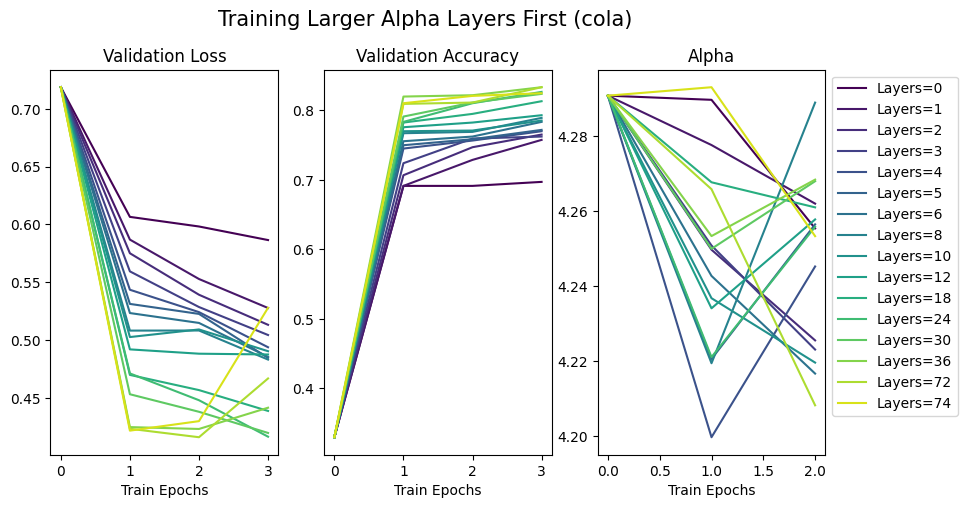

In [3]:
plt.figure(figsize=(10, 5))
first_val_loss = []
first_val_acc = []

layers = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 18, 24, 30, 36, 72, 74]
cmap = colormaps[cmp]
# cmap =  get_cmap(cmp, len(layers)))

for l_idx, layer in enumerate(layers):
    base_path = f"task_{task}/lay_norm_False/alpha_asc_False/layers_{layer}/lr2e-5_epoch3_bs32/"
    
    path = os.path.join(base_path, 'baseline.npy')
    
    alpha_vals = []
    for epoch in range (0, 3, 1):
        csv_path = os.path.join(base_path, 'stats', f'epoch_{epoch}.csv')
        df = pd.read_csv(csv_path)
        alpha_vals.append(np.mean(df['alpha'][2:]))

    baseline = np.load(path, allow_pickle=True).item()
    first_val_loss.append(baseline['val_loss_base'])
    first_val_acc.append(baseline['val_acc_base'])
    
    plt.subplot(1, 3, 1)
    plt.plot(baseline['val_loss_base'], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.title('Validation Loss')
    
    # plt.subplot(1, 5, 2)
    # plt.plot(baseline['val_loss_base'][:], label = f'Layers={layer}', c=cmap(l_idx/len(layers)))
    # plt.ylim([0, 0.1])
    # plt.title('Validation Loss (Zoomed)')
    
    plt.subplot(1, 3, 2)
    plt.plot(baseline['val_acc_base'], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.title('Validation Accuracy')
    
    # plt.subplot(1, 5, 4)
    # plt.plot(baseline['val_acc_base'][:], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    # plt.ylim([0.96, 0.998])
    # plt.title('Validation Accuracy (Zoomed)')
    
    plt.subplot(1, 3, 3)
    plt.plot(alpha_vals[:], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('Alpha')
    
plt.suptitle(f'Training Larger Alpha Layers First ({task})', fontsize=15, y=1)

Text(0.5, 1, 'Training Smaller Alpha Layers First (cola)')

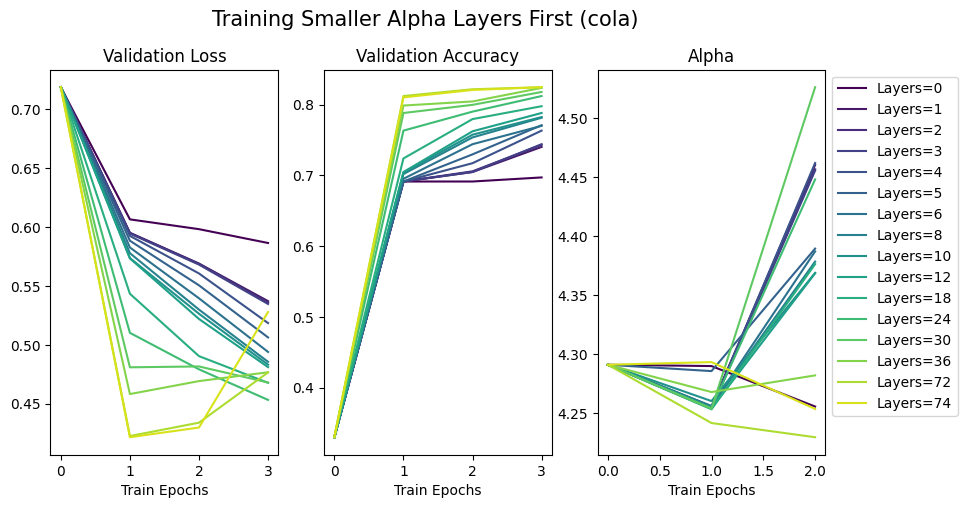

In [4]:
plt.figure(figsize=(10, 5))
first_val_loss = []
first_val_acc = []

layers = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 18, 24, 30, 36, 72, 74]
cmap =  colormaps[cmp]

for l_idx, layer in enumerate(layers):
    base_path = f"task_{task}/lay_norm_False/alpha_asc_True/layers_{layer}/lr2e-5_epoch3_bs32/"
    
    path = os.path.join(base_path, 'baseline.npy')
    
    alpha_vals = []
    for epoch in range (0, 3, 1):
        csv_path = os.path.join(base_path, 'stats', f'epoch_{epoch}.csv')
        df = pd.read_csv(csv_path)
        alpha_vals.append(np.mean(df['alpha'][2:]))

    baseline = np.load(path, allow_pickle=True).item()
    first_val_loss.append(baseline['val_loss_base'])
    first_val_acc.append(baseline['val_acc_base'])
    
    plt.subplot(1, 3, 1)
    plt.plot(baseline['val_loss_base'], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.title('Validation Loss')
    
    # plt.subplot(1, 5, 2)
    # plt.plot(baseline['val_loss_base'][:], label = f'Layers={layer}', c=cmap(l_idx/len(layers)))
    # plt.ylim([0, 0.1])
    # plt.title('Validation Loss (Zoomed)')
    
    plt.subplot(1, 3, 2)
    plt.plot(baseline['val_acc_base'], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.title('Validation Accuracy')
    
    # plt.subplot(1, 5, 4)
    # plt.plot(baseline['val_acc_base'][:], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    # plt.ylim([0.96, 0.998])
    # plt.title('Validation Accuracy (Zoomed)')
    
    plt.subplot(1, 3, 3)
    plt.plot(alpha_vals[:], label=f'Layers={layer}', c=cmap(l_idx/len(layers)))
    plt.xlabel('Train Epochs')
    plt.legend(bbox_to_anchor=(1, 1))
    plt.title('Alpha')
    
plt.suptitle(f'Training Smaller Alpha Layers First ({task})', fontsize=15, y=1)

In [5]:
dictionary = {
    'False': {'first_val_loss':[],
    "first_val_acc":[], 'alpha_vals':[]},
    'True': {'first_val_loss':[],
    "first_val_acc":[], 'alpha_vals':[]}
}


for key in dictionary:
    layers = [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 18, 24, 30, 36, 72, 74]
    cmap =  colormaps[cmp]
    
    for l_idx, layer in enumerate(layers):
        base_path = f"task_{task}/lay_norm_False/alpha_asc_{key}/layers_{layer}/lr2e-5_epoch3_bs32/"
        path = os.path.join(base_path, 'baseline.npy')
        
        alpha_vals = []
        for epoch in range(0, 3, 1):
            stats_path = os.path.join(base_path, 'stats', f'epoch_{epoch}.csv')
            df = pd.read_csv(stats_path)
            alpha_vals.append(np.mean(df['alpha'][2:]))
        
        baseline = np.load(path, allow_pickle=True).item()
        dictionary[key]['first_val_loss'].append(baseline['val_loss_base'])
        dictionary[key]['first_val_acc'].append(baseline['val_acc_base'])
        dictionary[key]['alpha_vals'].append(alpha_vals)
        
    dictionary[key]['first_val_loss'] = np.array(dictionary[key]['first_val_loss']) # type: ignore
    dictionary[key]['first_val_acc'] = np.array(dictionary[key]['first_val_acc']) # type: ignore
    dictionary[key]['alpha_vals'] = np.array(dictionary[key]['alpha_vals']) # type: ignore

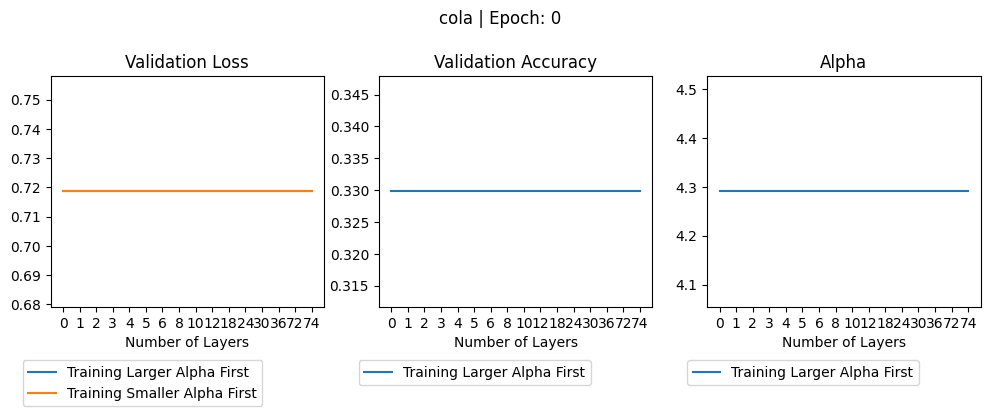

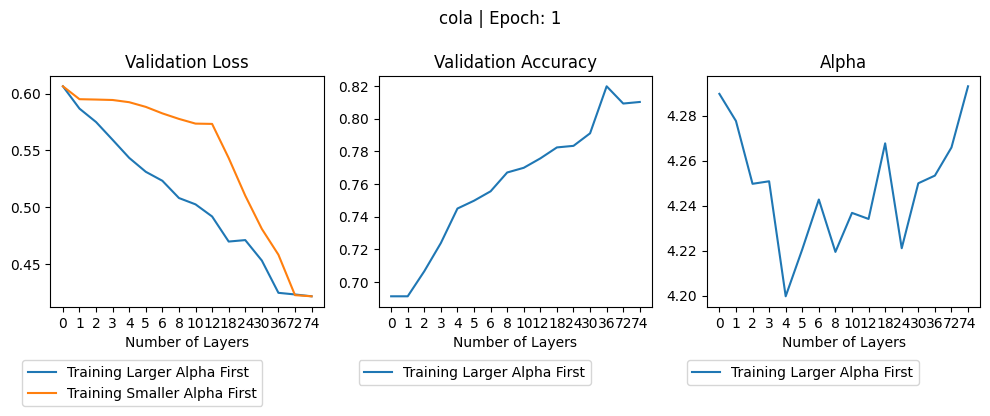

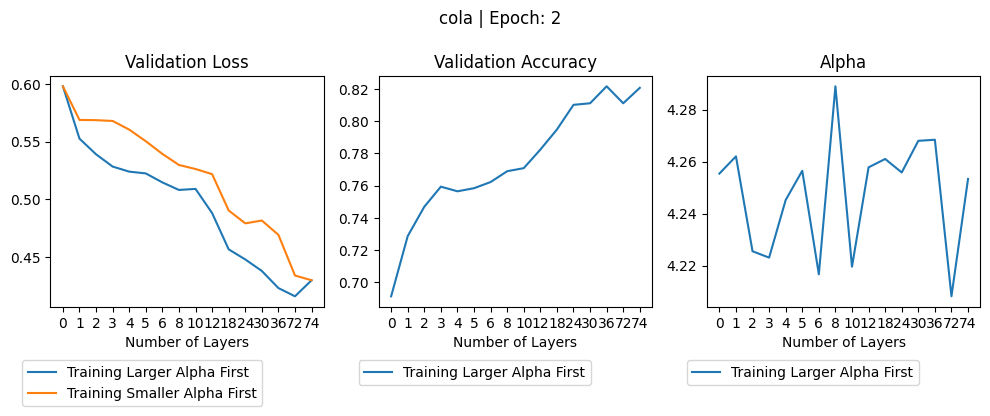

In [6]:
layer_cnt = len(layers)

for i in range(0, 3, 1):
    plt.figure(figsize=(12, 3))

    plt.subplot(1, 3, 1)
    plt.plot(
        range(layer_cnt), dictionary["False"]["first_val_loss"][:, i], # type: ignore
        markersize=5,
        label="Training Larger Alpha First"
    )
    plt.plot(
        range(layer_cnt), dictionary["True"]["first_val_loss"][:, i], # type: ignore
        markersize = 5,
        label="Training Smaller Alpha First"
    )
    plt.xticks(range(layer_cnt), layers)
    plt.legend(bbox_to_anchor=(0.8, -0.2))
    plt.xlabel('Number of Layers')
    plt.title('Validation Loss')
    
    plt.subplot(1, 3, 2)
    plt.plot(
        range(layer_cnt), dictionary["False"]["first_val_acc"][:, i], # type: ignore
        markersize=5,
        label="Training Larger Alpha First"
    )
    plt.xticks(range(layer_cnt), layers)
    plt.xlabel('Number of Layers')
    plt.title('Validation Accuracy')
    plt.legend(bbox_to_anchor=(0.8, -0.2))
    
    plt.subplot(1, 3, 3)
    plt.plot(
        range(layer_cnt), dictionary["False"]["alpha_vals"][:, i], # type: ignore
        markersize=5,
        label="Training Larger Alpha First"
    )
    plt.xticks(range(layer_cnt), layers)
    plt.xlabel('Number of Layers')
    plt.title('Alpha')
    plt.legend(bbox_to_anchor=(0.8, -0.2))
    
    plt.suptitle(f'{task} | Epoch: {i}', y=1.1)
    
    plt.show()